# RNN Model Train Step (Etapa do Treinamento do Modelo LSTM)
**[EN-US]**

Training and evaluation stage of the LSTM model, and then we save the model and its respective trained weights.

In this step we perform:
* Model definition;
* Model training;
* Model evaluation;
* Saving the model and trained weights.

**[PT-BR]**

Etapa do treinamento e avaliação do modelo LSTM, para depois, salvarmos o modelo e seus respectivos pesos treinados.

Nesta etapa realizamos:
* Definição do modelo;
* Treinamento do modelo;
* Avaliação do modelo;
* Salvamento do modelo e dos pesos treinados.

## Table of Contents
* [Packages](#1)
* [Loading the Data](#2)
* [Hyperparameters Tuning](#3)
* [RNN Model](#4)
    * [Embedding](#4.1)
    * [LSTM Layer](#4.2)
* [Bidirectional LSTM Model Train](#5)
    * [Model Architecture](#5.1)
* [Inference](#6)

<a name="1"></a>
## Packages (Pacotes)
**[EN-US]**

Packages used in the system.
* [pandas](https://pandas.pydata.org/): is the main package for data manipulation;
* [numpy](www.numpy.org): is the main package for scientific computing;
* [pickle](https://docs.python.org/3/library/pickle.html): implements binary protocols for serializing and de-serializing a Python object structure;
* [tensorflow](https://www.tensorflow.org/): framework that makes it easy to create ML models that can run in any environment;
* [skopt](https://scikit-optimize.github.io/stable/): is a simple and efficient library to minimize (very) expensive and noisy functions;
* [matplotlib](http://matplotlib.org): is a library to plot graphs;
* [os](https://docs.python.org/3/library/os.html): built-in module, provides a portable way of using operating system dependent functionality;
* [sys](https://docs.python.org/3/library/sys.html): provides access to some variables used or maintained by the interpreter and to functions that interact strongly with the interpreter;
* [src](../src/): package with all the codes for all utility functions created for this system. Located inside the `../src/` directory.

**[PT-BR]**

Pacotes utilizados no sistema.
* [pandas](https://pandas.pydata.org/): é o principal pacote para manipulação de dados;
* [numpy](www.numpy.org): é o principal pacote para computação científica;
* [pickle](https://docs.python.org/3/library/pickle.html): implementa protocolos binários para serializar e desserializar uma estrutura de objeto Python;
* [tensorflow](https://www.tensorflow.org/): framework que facilita a criação de modelos de machine learning que podem ser executados em qualquer ambiente;
* [skopt](https://scikit-optimize.github.io/stable/): é uma biblioteca simples e eficiente para minimizar funções (muito) caras computacionalmente e ruidosas;
* [matplotlib](http://matplotlib.org): é uma biblioteca para plotar gráficos;
* [os](https://docs.python.org/3/library/os.html): módulo integrado, fornece uma maneira portátil de usar funcionalidades dependentes do sistema operacional;
* [sys](https://docs.python.org/3/library/sys.html): fornece acesso a algumas variáveis usadas ou mantidas pelo interpretador e a funções que interagem fortemente com o interpretador;
* [src](../src/): pacote com todos os códigos de todas as funções utilitárias criadas para esse sistema. Localizado dentro do diretório `../src/`.

In [82]:
import pandas as pd
import numpy as np
import pickle
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from skopt import gp_minimize

import os
import sys
PROJECT_ROOT = os.path.abspath( # Getting Obtaining the absolute normalized version of the project root path (Obtendo a versão absoluta normalizada do path raíz do projeto)
    os.path.join( # Concatenating the paths (Concatenando os paths)
        os.getcwd(), # # Getting the path of the notebooks directory (Obtendo o path do diretório dos notebooks)
        os.pardir # Gettin the constant string used by the OS to refer to the parent directory (Obtendo a string constante usada pelo OS para fazer referência ao diretório pai)
    )
)
# Adding path to the list of strings that specify the search path for modules
# Adicionando o path à lista de strings que especifica o path de pesquisa para os módulos
sys.path.append(PROJECT_ROOT)
from src.rnn_model_train import *

**[EN-US]**

> **Note**: the codes for the utility functions used in this system are in the `rnn_model_train.py` script within the `../src/` directory.

**[PT-BR]**

> **Nota**: os códigos para as funções utilitárias utilizadas nesse sistema estão no script `rnn_model_train.py` dentro do diretório `../src/`.

<a name="2"></a>
## Loading the Data (Carregando os Dados)
**[EN-US]**

We will read each subset from disk, define the global variables for creating the dataset and model, and we will create the `tensorflow.data.Dataset` for each subset.

Reading each of the subsets from the `../data/preprocessed/` directory and plotting their dimensions.

**[PT-BR]**

Vamos ler cada subset do disco, definir as variáveis globais para a criação do dataset e do modelo, e vamos criar o `tensorflow.data.Dataset` de cada subset.

Lendo cada um dos subsets do diretório `../data/preprocessed/` e plotando as suas dimensões.

In [9]:
# Subset names
# Nomes dos subsets
files = ['train', 'validation', 'test']
datasets = []
# Looping through each name
# Percorrendo cada nome
for file in files:
    # Reading each subset and adding it to the list for later extraction
    # Lendo cada subset e adicionando na lista para extração posteriormente
    with open(f'../data/preprocessed/{file}_tokens.npy', 'rb') as f:
        datasets.append(np.load(f))

# Extracting each subset from the `datasets` list
# Extraindo cada subset da lista `datasets`
train_corpus, val_corpus, test_corpus = datasets
print(f'Train set shape: {train_corpus.shape}\nValidation set shape: {val_corpus.shape}\nTest set shape: {test_corpus.shape}')

Train set shape: (9682, 167)
Validation set shape: (3227, 167)
Test set shape: (3228, 167)


**[EN-US]**

Setting global variables to create `tensorflow.data.Dataset` and global variables to create the model.

**[PT-BR]**

Definindo as variáveis globais para criar o `tensorflow.data.Dataset` e as variáveis globais para a criação do modelo.

In [11]:
# Dataset global variables
# Variáveis globais do dataset
BATCH_SIZE = 32
BUFFER_SIZE = 1000

# Model global variables
# Variáveis globais do modelo
tokenizer = pickle.load(open('../models/vectorizer.pkl', 'rb'))
MAX_LEN = tokenizer['config']['output_sequence_length']
EMBEDDING_DIM = 16
DROPOUT_RATE = [.5, .5]
LR = 5e-3
VOCAB_SIZE = len(tokenizer['vocabulary']) # Carregando o vocabulário do tokenizer treinado # Loading vocabulary from trained tokenizer
print(f'Vocabulary size: {VOCAB_SIZE}\nMax length: {MAX_LEN}')

Vocabulary size: 1000
Max length: 166


Creating `tensorflow.data.Dataset` for each subset and plotting the training set dimension (Criando o `tensorflow.data.Dataset` para cada subset e plotando a dimensão do training set).

In [13]:
train_set = create_batch_dataset(train_corpus, BATCH_SIZE, BUFFER_SIZE, shuffle=True)
val_set = create_batch_dataset(val_corpus, BATCH_SIZE, BUFFER_SIZE, shuffle=True)
test_set = create_batch_dataset(test_corpus, BATCH_SIZE, BUFFER_SIZE, shuffle=True)

train_batch = next(train_set.as_numpy_iterator())
print(f"Shape of the train batch: {train_batch[0].shape}")

Shape of the train batch: (32, 166)


<a name="3"></a>
## Hyperparameters Tuning (Otimização dos Hiperparâmetros)
**[EN-US]**

The method used to search for the best hyperparameters for the model was `Bayesian optimization`.

Computing Bayesian Optimization.

**[PT-BR]**

O método utilizado para a busca dos melhores hiperparâmetros para o modelo foi a otimização bayesiana (`bayesian optimization`).

Calculando a otimização bayesiana.

In [90]:
# Defining the range for testing learning rate
# Definindo a faixa para teste da learning rate
space = [
    (1e-4, 1e-1, 'log-uniform') # learning rate
]

# Performing Bayesian optimization
# Performando a bayesian optimization
#opt = gp_minimize(hyperparams_tune, space, random_state=42, verbose=0, n_calls=5, n_random_starts=2)
# Output with the best combinations of hyperparameters
# Output com as melhores combinações dos hiperparâmetros
#print(f'Learning rate: {opt.x[0]:.4f}')

<a name="4"></a>
## RNN Model (Modelo RNN)
**[EN-US]**

We can try using a standard neural network for this task, or maybe even logistic regression, or Naive Bayes, but these models don't perform well for NLP tasks, and the main problems are:
* Inputs and outputs may have different lengths in different examples. Generally, we fill all inputs to a maximum length, but this still doesn't seem like a good representation.
* Does not share features learned between different positions (time steps $t$) of texts. We like effects similar to CNNs for sequential data, where we want things learned for one part of the image to quickly generalize to other parts of the image.
    * If the standard neural network, with the value "Iron Man" for input unit 1 (time step 1), analyzes that this is part of a person's name, then, wouldn't it be good if we discovered that "Iron Man" appearing in another input unit (time step $t \neq 1$), this also means that this could be a person's name.
* The FC (Dense) layer will have a huge number of parameters. As with ConvNets, using a good representation will also allow us to reduce the number of parameters in our model.

For these reasons, we use a sequential network, which will allow us to predict sentiments in complex sentences, which we would not be able to classify correctly using simpler methods, because they miss important information. At each time step $t$, the RNN passes its activation to the next time step for use. To start everything off, we will also have an activation invented at time 0, $a^{<0>}$, which is a vector of 0s, but we can also initialize it randomly.
* We denote the time step $t$ as $<t>$, that is, $x^{<1>}$, is the token of time step 1 of the input $x$.

Each of the units (words) represents the calculations made in each time step. The calculations performed in the last step contain information about all the words in that sentence. The RNN examines the data from left to right, and the parameters used for each time step are shared. The parameters that govern the connection of $x^{<1>}$ with the hidden layer, will be a set $W_{ax}$ of parameters, and are the same $W_{ax}$ parameters that it uses for each time step. Activations, horizontal connections will be governed by $W_{aa}$, similar to $W_{ax}$. Also similar to $W_{ax}$, $W_{ya}$ governs the output predictions.

The magic of RNNs is that the information for each word in the sentence is multiplied by the same weights, $W_x$. The information propagated from start to finish is multiplied by $W_h$. The first block is repeated for each word in the sentence, so the only parameters that can be learned are $W_x$, $W_h$ and $W$, the weights used to make the final prediction. This is why they are called recurrent neural networks, they calculate values that are repeatedly transmitted to themselves until a prediction is made. The main advantage of RNNs is that they propagate information in sentences and their calculations share most of the parameters.

The hidden states in each time step $t$ are calculated with an activation function $g$, with the arguments equal to the product between a matrix of parameters $W_h$ and the previous hidden states $h^{<t - 1>}$, this is concatenated with the input variable $x^{<t>}$, plus the bias $b_h$:
$$h^{<t>} = g(W_h [h^{<t - 1>}, x^{<t>}] + b_h)$$
Complete equation, where $x^{<t>}$ and $h^{<t - 1>}$ are multiplied by different parameters and the resulting vectors are added element by element:
$$h^{<t>} = g(W_{hh} h^{<t - 1>} + W_{hx} x^{<t>} + b_h)$$
* $W_h[h^{<t - 1>}, x^{<t>}]$ is the same as multiplying $W_{hh}$ by $h^{<t - 1>}$ and $W_{hx}$ by $x^{<t>}$. So we can concatenate.
* $W_h$ denotes the horizontal concatenation of the weight matrices $W_{hh}$ and $W_{hx}$.
    * The join over the vertical limit is called `horizontal concatenation` or `horizontal stack`, that is, $W_h = | W_{hh} | W_{hx} |$.

After calculating the hidden state in time step $t$, it is possible to obtain the prediction $\hat{y}^{<t>}$ using the activation function $g$, with arguments equal to the product between the hidden state and some parameters $W$, plus the bias term $b_y$:
$$\hat{y}^{<t>} = g(W_{yh} h^{<t>} + b_y)$$

These 2 equations together represent all the math behind a simple RNN. The first cell of the RNN receives as input the previous hidden state $h^{<t_0>}$ and the current variable $x^{<t_1>}$, which can be the first word in a sentence. To obtain the current hidden state $h^{<t_1>}$, we first need to obtain the products of $x^{<t_1>}$ and $h^{<t_0>}$ with the respective parameters and then add the vectors element-wise. We then pass the resulting vector into an activation function.
$$h^{<t>} = g(W_{hh} h^{<t - 1>} + W_{hx} x^{<t>} + b_h)$$
With the resulting value, we can calculate $\hat{y}^<t>$ by multiplying the current hidden state, with a set of parameters $W_{yh}$ and passing through another activation function.
$$\hat{y}^{<t>} = g(W_{yh} h^{<t>} + b_y)$$
The hidden states $h^{<t>}$ are the variables that cause the RNNs to propagate information over time or, in other words, through different positions in the sentence. In each time step the recurrent units have 2 inputs.

We can think of RNNs as versatile tools that can be tailored to the task. Therefore, according to the nature of the inputs and outputs, there are many different types of RNN architectures:

* `One to One`: takes as input a set of low features or uncorrelated features $X$ and returns a single output $y$. Let's say we have a list of scores for our favorite team. As inputs, we can have an RNN that predicts our team's position on the leaderboard. However, this RNN is not much different from a conventional neural network. It only has additional hidden states $h^{<t_0>}$. Therefore, for this type of task, RNNs are not very useful.

* `One to Many`: if we want a neural network that takes an arbitrary image and generates a caption describing the content of that image (caption generation task), we can create an RNN. One to Many, because our RNN takes a single image and generates multiple words to describe it.

* `Many to One`: if we have a sentence, our RNN would take each word in the sentence as input in different steps, propagate the information from start to finish and generate a single output, the feeling, for example.

* `Many to Many`: involve multiple inputs and multiple outputs. For example, in machine translation, we have a sentence in one language and we want to get its equivalent in another language, we use an `encoder` and a `decoder` to translate from one language to another. We can use a machine translation system that has RNNs for both the encoder and decoder, because they propagate information from beginning to end and this is what makes them capable of capturing the general meaning of sentences. The traditional `seq2seq` model was introduced by Google in 2014. Basically, it works by receiving a sequence of items, such as words, and its output is another sequence. The way this is done is by mapping variable-length sequences to a fixed-length memory, which in machine translation encodes the general meaning of the sentences. For example, we can take variable-length text and encode it into a fixed-dimension vector, like 300. This feature is what made this model a powerhouse for machine translation. Furthermore, inputs and outputs do not need to have corresponding lengths, which is a desirable feature when translating texts. In the seq2seq model, LSTMs and GRUs are typically used to avoid these problems. In a seq2seq model we have an encoder and a decoder:
    * `Encoder`: receives tokens as input and returns their final hidden states $h_T$ as output.
    * `Decoder`: receives the encoder output, the final hidden states, which are used by the decoder as initial hidden states to generate the translated sentence in the target language.

Vanilla (simple) RNNs are limited in the sense that, for long sequences of words, information tends to disappear, that is, the problem of vanishing/exploding gradients. Therefore, more complex models were created to deal with long sequences and exponentially reduce this problem, these models are `GRU` and `LSTM`. Deep RNNs are useful because they allow us to capture dependencies that we otherwise could not have captured using shallow RNNs. Both architectures are derived from Vanilla (simple) RNN.
* `Vanishing gradients`: When we calculate backprop, the gradients can become very small and as a result the model will not learn anything.
* `Exploding gradients`: if the partial derivatives are greater than 1, the contribution to the gradient goes to infinity, which causes convergence problems during training.

**[PT-BR]**

Podemos tentar usar uma rede neural padrão para essa tarefa, ou talvez até uma regressão logística, ou um Naive Bayes, mas esses modelos não obtém um bom desempenho para tarefas de NLP, e os problemas principais são:
* Inputs e outputs podem ter comprimentos diferentes em exemplos diferentes. Geralmente, preenchemos todos os inputs até um comprimento máximo, mas isso ainda não parece uma boa representação.
* Não compartilha features aprendidas entre diferentes posições (time steps $t$) de textos. Gostamos de efeitos semelhantes as CNNs para dados sequênciais, onde desejamos que as coisas aprendidas para uma parte da imagem, se generalizem rapidamente para outras partes da imagem.
    * Caso a rede neural padrão, com o valor "Iron Man" para a input unit 1 (time step 1), analisa que isso faz parte do nome de uma pessoa, então, não seria bom se descobrissemos que aparecendo "Iron Man" em outra input unit (time step $t \neq 1$), isso também significa que esse pode ser o nome de uma pessoa.
* A FC (Dense) layer terá um número enorme de parâmetros. Assim como nas ConvNets, usar uma boa representação também permitirá reduzir o número de parâmetros do nosso modelo.

Por esses motivos, utilizamos uma rede sequencial, que nos permitirá prever sentimentos em frases complexas, que não conseguiríamos classificar corretamente usando métodos mais simples, porque eles perdem informações importantes. Em cada time step $t$, a RNN passa sua ativação para o próximo time step para ser usada. Para começar tudo, também teremos uma ativação inventada no tempo 0, $a^{<0>}$, que é um vetor de 0s, mas também podemos inicializá-lo aleatoriamente.
* Denotamos o time step $t$ como $<t>$, ou seja, $x^{<1>}$, é o token do time step 1 do input $x$.

Cada uma das units (palavras) representa os cálculos feitos em cada time step. Os cálculos realizados no último step contêm informações de todas as palavras dessa frase. A RNN examina os dados da esquerda para a direita, e os parâmetros usados para cada time step são compartilhados. Os parâmetros que governam a conexão de $x^{<1>}$ com o hidden layer, serão um set $W_{ax}$ de parâmetros, e são os mesmo parâmetros $W_{ax}$ que ela usa para cada time step. As ativações, conexões horizontais serão governadas por $W_{aa}$, semelhante à $W_{ax}$. Também semalhante á $W_{ax}$, $W_{ya}$ governa os output predictions.

A mágica das RNNs é que as informações de cada palavra na frase são multiplicadas pelos mesmos pesos, $W_x$. A informação propagada do início ao fim é multiplicada por $W_h$. O primeiro bloco é repetido para cada palavra na frase, então, os únicos parâmetros que podem ser aprendidos são os $W_x$, $W_h$ e $W$, os pesos utilizados para fazer a previsão final. É por isso que elas são chamadas de recurrent neural networks, elas calculam valores que são transmitidos repetidamente para si mesmas até que uma previsão seja feita. A principal vantagem das RNNs é que elas propagam informações em frases e seus cálculos compartilham a maioria dos parâmetros.

Os hidden states em cada time step $t$ são calculados com uma função de ativação $g$, com os argumentos iguais ao produto entre uma matriz de parâmetros $W_h$ e os hidden states anteriores $h^{<t - 1>}$, isso é concatenado com a variável de input $x^{<t>}$, mais o viés $b_h$:
$$h^{<t>} = g(W_h [h^{<t - 1>}, x^{<t>}] + b_h)$$
Equação completa, onde $x^{<t>}$ e $h^{<t - 1>}$ são multiplicados por parâmetros diferentes e os vetores resultantes são somados element a elemento:
$$h^{<t>} = g(W_{hh} h^{<t - 1>} + W_{hx} x^{<t>} + b_h)$$
* $W_h[h^{<t - 1>}, x^{<t>}]$ é o mesmo que multiplicas $W_{hh}$ por $h^{<t - 1>}$ e $W_{hx}$ por $x^{<t>}$. Portanto, podemos concatenar.
* $W_h$ denota a concatenação horizontal das matrizes de peso $W_{hh}$ e $W_{hx}$.
    * A junção sobre o limite vertical é chaamda de `horizontal concatenation` ou `horizontal stack`, ou seja, $W_h = | W_{hh} | W_{hx} |$.

Depois de calcularmos o hidden state no time step $t$, é possível obtermos a previsão $\hat{y}^{<t>}$ usando a função de ativação $g$, com argumentos iguais ao produto entre o hidden state e alguns parâmetros $W$, mais o termo do viés $b_y$:
$$\hat{y}^{<t>} = g(W_{yh} h^{<t>} + b_y)$$

Essas 2 equações juntas representam toda a matemática por trás de um RNN simples. A primeira cell da RNN recebe como input o hidden state anterior $h^{<t_0>}$ e a variável atual $x^{<t_1>}$, que pode ser a primeira palavra em uma frase. Para obtermos o hidden state atual $h^{<t_1>}$, primeiro precisamos obter os produtos de $x^{<t_1>}$ e $h^{<t_0>}$ com os respectivos parâmetros e, em seguida, somamos os vetores element-wise. Em seguida, passamos o vetor resultante em uma função de ativação.
$$h^{<t>} = g(W_{hh} h^{<t - 1>} + W_{hx} x^{<t>} + b_h)$$
Com o valor resultante, podemos calcular o $\hat{y}^<t>$ multiplicando o hidden state atual, com um set de parâmetros $W_{yh}$ e passando por outra função de ativação.
$$\hat{y}^{<t>} = g(W_{yh} h^{<t>} + b_y)$$
As hidden states $h^{<t>}$ são as variávels que fazem com que as RNNs propaguem informações ao longo do tempo ou, em outras palavras, por meio de posições diferentes na frase. Em cada time step as recurrent units têm 2 entradas.

Podemos pensar em RNNs como ferramentas versáteis que podem ser moldadas de acordo com a tarefa. Portanto, de acordo com a natureza dos inputs e outputs, existem muitos tipos diferentes de arquiteturas de RNNs:

* `One to One`: toma como input um set de low features ou features não correlacionadas $X$ e retorna um único output $y$. Digamos que temos uma lista de pontuações do nosso time favorito. Como inputs, podemos ter uma RNN que preve a posição de nossa equipe na tabela de classificação. No entanto, essa RNN não é muito diferente de uma rede neural convencional. Ela tem apenas hidden states $h^{<t_0>}$ adicionais. Portanto, para esse tipo de tarefa, as RNNs não são muito úteis.

* `One to Many`: se queremos uma rede neural que pegue uma imagem arbitrária e gere uma caption descrevendo o conteúdo dessa imagem (caption generation task), podemos criar uma RNN. One to Many, porque nossa RNN pega uma única imagem e gera várias palavras para descrevê-la.

* `Many to One`: se tivermos uma frase, a nossa RNN pegaria cada palavra da frase como input em diferentes steps, propagaria as informações do início ao fim e geraria um único output, o sentimento, por exemplo.

* `Many to Many`: envolvem vários inputs e vários outputs. Por exemplo, em machine translation, temos uma frase em um idioma e desejamos obter seu equivalente em outro idioma, usamos um `encoder` e um `decoder` para traduzir de um idioma para outro. Podemos usar um sistema de machine translation que tenha RNNs para ambos o encoder e decoder, porque elas propagam informações do início ao fim e é isso que as torna capazes de capturar o significado geral das frases. O modelo tradicional `seq2seq` foi introduzido pelo Google em 2014. Basicamente, ele funciona recebendo uma sequência de itens, como palavras, e seu output é outra sequência. A maneira como isso é feito, é mapeando sequências de comprimento variável (variable-length sequences) para uma memória de comprimento fixo (fixed-length memory), que em machine translation, encodes o signifcado geral das frases. Por exemplo, podemos ter um texto de tamanho variável e codificá-lo em um vetor de dimensão fixa, como 300. Essa feature é o que tornou esse modelo uma potência para machine translation. Além disso, os inputs e outputs não precisam ter comprimentos correspondentes, o que é uma feature desejável ao traduzir textos. No modelo seq2seq, LSTMs e GRUs são normalmente usados para evitar esses problemas. Em um modelo seq2seq temos um encoder e um decoder:
    * `Encoder`: recebe tokens como input e retorna seus hidden states finais $h_T$ como output.
    * `Decoder`: recebe o output do encoder, os hidden states finais, que são usados pelo decoder como initial hidden states para gerar a frase traduzida no idioma de destino.

Vanilla (simples) RNNs são limitadas no sentido de que, para longas sequências de palavras, as informações tendem a desaparecer, ou seja, o problema dos vanishing/exploding gradients. Portanto, modelos mais complexos foram criados para lidarmos com sequências longas e reduzir exponencialmente esse problema, esses modelos são a `GRU` e a `LSTM`. Deep RNNs são úteis porque permitem capturar dependências que, de outra forma, não poderíamos ter capturado usando shallow (rasas) RNNs. Ambas arquiteturas são derivadas da Vanilla (simples) RNN.
* `Vanishing gradients`: quando calculamos o backprop, os gradients podem se tornar muito pequenos e, como resultado, o modelo não aprenderá nada.
* `Exploding gradients`: se as derivadas parciais forem maiores que 1, a contribuição para o gradient vai para o infinito, o que causa problemas de convergência durante o treinamento.

<a name="4.1"></a>
### Embedding
**[EN-US]**

Word embeddings is the method that encodes the meaning of the word into a vector space. When we encode and plot a word in 2D, similar words tend to be found close to each other. In practice, we will find embeddings with hundreds of dimensions, and we can think of each dimension as a number that tells us something about the word. Word embeddings have been one of the most important ideas in NLP. What we do to learn word embeddings is have a vocabulary of 10,000 words, for example, and we will learn a vector $e_1$, up to $e_{\mathrm{VOCAB_SIZE}}$, which just learns a fixed encoding, learns a fixed embedding for each of the words $e$ in our vocabulary $V$. We can allow our algorithms to generalize much better.

Encoding the meaning of words is also the first step to encoding the meaning of entire sentences, which is the basis for NLP use cases like question answering and neural machine translation, for example. Word embeddings represent words in a vector form that, at the same time:
* It has a relatively low dimension, making it practical for calculations.
* Allows us to encode the meaning of the word. It carries the meaning of words, making it possible to determine how semantically similar the words are.
    * In general vocabularies, generally the vector for 'forest' will be similar to the vector for 'tree', which is very different from the vector for 'ticket'.
$$\text{forest } \approx \text{ tree }\ \ \text{ forest} \neq \text{ ticket}$$
* Allows you to make analogies, such as discovering the missing word in 'Paris is to France as Rome is to ?'
$$\text{Paris:France :: Rome:?}$$

There are many types of possible methods for learning word embeddings, we create machine learning models to learn word embeddings. The model performs a `learning task`, and the main by-products of this task are word embeddings. For example, the task could be to learn to predict a word based on surrounding words in any sentence in the corpus, as in the case of `continuous bag-of-words (CBOW)`. The specificity of the task is what will ultimately define the meaning of individual words.

The task is `self-supervised`, it is both unsupervised in the sense that the input data and corpus are unlabeled, and supervised in the sense that the data itself provides the necessary context that would normally constitute labels. Therefore, the corpus is an independent dataset that contains training data and data that allows task supervision.
* self-supervised learning: it is a mixture of unsupervised learning and supervised learning.

Word embeddings can be tuned by various hyperparameters, as in any model. One of these hyperparameters is the dimension of the word embedding vectors. In practice, this size normally varies from a few hundred to a few thousand. Using higher dimensions captures more subtle meanings, but it is more computationally expensive, both in terms of training time and later, when using word embedding vectors, this ends up resulting in diminishing returns.

To input the corpus into the machine learning model, the corpus content must first be transformed into a suitable mathematical representation of words in numbers (tokenization). The representation depends on the specifics of the model, but is generally based on simple representations, such as integer based word indices or one-hot vectors.

**[PT-BR]**

Word embeddings é o método que codifica o significado da palavra em um espaço vetorial. Ao codificarmos e plotarmos uma palavra em 2D, palavras semelhantes tendem a ser encontradas próximas umas das outras, na prática, encontraremos embeddings com centenas de dimensões e, podemos pensar em cada dimensão como um número que nos diz algo sobre a palavra. Word embeddings tem sido uma das ideias mais importantes em NLP. O que fazemos para aprender word embeddings é ter um vocabulários de 10.000 palavras, por exemplo, e aprenderemos um vetor $e_1$, até $e_{\mathrm{VOCAB_SIZE}}$, que apenas aprende um encoding fixo, aprende um embedding fixo para cada uma das palavras $e$ em nosso vocabulário $V$. Podemos permitir que nossos algoritmos se generalizem muito melhor.

Codificar o significado das palavras também é o primeiro passo para codificar o significado de frases inteiras, que é a base para casos de uso de NLP como question aswering e neural machine translation, por exemplo. Word embeddings representa palavras em uma forma vetorial que, ao mesmo tempo:
* Tem uma dimensão relativamente baixa, tornando-á pratica para cálculos.
* Nos permite codificar o significado da palavra. Carrega o significado das palavras, possibilitando determinar o quão semanticamente similares as palavras são.
    * Em vocabulários no geral, geralmente o vetor para 'forest' será similar ao vetor para 'tree', o que é muito diferente do vetor de 'ticket'.
$$\text{forest } \approx \text{ tree }\ \ \text{ forest} \neq \text{ ticket}$$
* Permite fazer analogias, como descobrir que a palavra que falta em 'Paris é para France como Roma está para ?'
$$\text{Paris:France :: Rome:?}$$

Há muito tipos de método possíveis de aprender word embeddings, criamos modelos de machine learning para aprender as word embedding. O modelo executa uma `learning task`, e os principais subprodutos dessa tarefa são as word embeddings. Por exemplo, a task pode ser aprender a prever uma palavra com base nas palavras circundantes em qualquer frase do corpus, como no caso do `cotinuous bag-of-words (CBOW)`. A especificidade da tarefa é o que acabará por definir o significado das palavras individuais.

A task é `self-supervised (autosupervisionada)`, é tanto não supervisionada no sentido de que os dados de entrada e o corpus não estão rotulados, quanto supervisionada no sentido de que os dados em si fornecem o contexto necessário que normalmente constituiria os rótulos. Portanto, o corpus é um dataset independente que contém os dados de treinamento e os dados que permitem a supervisão da tarefa.
* self-supervised learning: é uma mistura de aprendizado não supervisionado e aprendizado supervisionado.

Word embeddings podem ser ajustadas por vários hiperparâmetros, como em qualquer modelo. Um desses hiperparâmetros é a dimensão dos word embedding vectors. Na prática, essa dimensão normalmente varia de algumas centenas a poucos milhares. Usar dimensões mais altas, capturamos significados mais sutis, mas é mais caro computacionalmente, tanto no que diz respeito ao tempo de treinamento, quanto posteriormente, ao usar os word embedding vectors, isso acaba resultando em retornos decrescentes.

Para inserir o corpus no modelo de machine learning, o conteúdo do corpus deve primeiro ser transformado em uma representação matemática adequada de palavras em números (tokenização). A representação depende das especificidades do modelo, mas geralmente é baseada nas representações simples, como inteiros (integer based words indices) ou one-hot vectors.

<a name="4.2"></a>
### LSTM Layer
**[EN-US]**

The LSTM (Long Short Term Memory) -- as well as the GRU (Gated Recurrent Unit) -- was created to reduce the problem of vanishing/exploding gradients in a simple RNN. The LSTM is the best solution to deal with the problem of vanishing gradients, more robust than a GRU unit. But they still suffer from vanishin/exploding gradients issues when processing very long sentences. So, transformers were created, which do not suffer from this problem.
> I will talk about transformers in the fine tuning of the DistilBERT model in the notebook `05_transformers_finetuning.ipynb`.

LSTMs are a special variety of simple RNNs, which are designed to deal with entire sequences of data, learning when to remember and forget, which is similar to what is done in GRU. An LSTM is essentially composed of:
* A `cell state`, which we can consider as its memory.
* A `hidden state (memory state)` where calculations are performed during training to decide what changes should be made.
* An LSTM has `multiple gates` that transform the states in the network. They discard irrelevant information and add new important information used to produce the output.

<img align='center' src='../figures/LSTM.png' style='width:800px;'>
The cell state passes through these gates and tracks the inputs as they arrive, each playing a role in deciding how much information should be passed on and how much should be left behind. The series of gates allows gradients to flow, avoiding the risk of `vanishing or exploding gradients`.

An LSTM unit stores information in the cell and hidden states, denoted by $c^{<t>}$ and $h^{<t>}$ respectively and, just like in Vanilla (simple) RNNs, we have the inputs $x^{<t>}$ and the outputs $\hat{y}^{<t>}$. Information flows through 3 different gates, in their respective order in which information flows:
1. `Forget gate`: first, the cell state passes through the forget gate. In this step, the previous inputs and hidden states are used to decide which cell state information is no longer important and discard it.
   $$\Gamma_f = \sigma(W_f [h_{t - 1}; x_t] + b_f)$$
2. `Input gate`: then, the input gate is used to decide which information from the inputs and previous hidden states is relevant and, therefore, is added to the cell state.
   $$\Gamma_i = \sigma(W_i [h_{t - 1}; x_t] + b_i)$$
3. `Output gate`: then, the output gate determines the cell state information that is stored in the hidden state and uses it to create an output at a given time step $t$.
   $$\Gamma_o = \sigma(W_o [h_{t - 1}; x_t] + b_o)$$

Gates allow gradients to flow without changes. Sigmoid activation functions with different trainable parameters are applied to the inputs and previous hidden states for the 3 gates. The use of sigmoid guarantees that the gate values are between 0 and 1. In practice, the values found in the vectors corresponding to each gate are very close to 0 or 1. With a value of 0, the gate is closed so that information does not reach, while a value of 1 allows information to flow freely.

Another significant calculation done within an LSTM is `candidate cell state`. To achieve this, we need to transform the information from previous hidden states and current inputs. The `tanh` activation function, typically used in different implementations, reduces information from previous hidden states and current inputs to be between -1 and 1. This non-linear transformation has been used in the past because it improves training performance, however, we can use other activations and test their behavior. Candidate cell (carry) state for time step $t$:
$$g = \mathrm{tanh}(W_g [h_{t - 1}; x_t] + b_g)$$

With the forget gate, input gate and candidate cell state, we can update the cell state. To obtain the new cell state, we add the information from the candidate cell state that passes through the input gate to the information from the cell state, which passes through the forget gate. Cell (Carry) state for time step $t$:
$$c_t = \Gamma_f . c_{t - 1} + \Gamma_i . g$$

We then calculate the new hidden state used to produce the output at a given time step $t$. To obtain the new hidden state, we pass the transformed information of the new cell state through the output port. In the new cell state, we first undergo tanh activation. However, the tanh function can be omitted. LSTM unit output for time step $t$:
$$h_t = \Gamma_{o_t} . \text{tanh}(c_t)$$

A limitation of this particular neural network architecture is that the prediction at a given time uses inputs or uses information from earlier inputs in the sequence, but not information later in the sequence. We will use a bidirectional LSTM to deal with this problem.

**[PT-BR]**

A LSTM (Long Short Term Memory) -- assim como a GRU (Gated Recurrent Unit) -- foi criada para reduzir o problema dos vanishing/exploding gradients de uma RNN simples. A LSTM é a melhor solução para lidar com o problema dos vanishing gradients, mais robusta do que uma GRU unit. Mas ainda sofrem com problemas de vanishin/exploding gradients ao processar frases muito longas. Portanto, foram criados os transformers, que não sofre com esse problema.
> Falarei sobre os transformers no fine-tuning do modelo DistilBERT no notebook `05_transformers_finetuning.ipynb`.

As LSTMs são uma variedade especial das RNNs simples, que foram projetadas para lidar com sequências inteiras de dados, aprendendo quando lembrar e esquecer, o que é similar ao que é feito na GRU. Um LSTM é essencialmente composto por:
* Uma `cell state`, que podemos considerar como a sua memória.
* Um `hidden state (memory state)` onde os cálculos são realizados durante o treinamento para decidir quais mudanças devem ser feitas.
* Um LSTM tem `multiple gates` que transformam os states na rede. Descartam informações irrelevantes e adicionam novas informações importantes usadas para produzir o output.

<img align='center' src='../figures/LSTM.png' style='width:800px;'>
A cell state passa por esses gates e rastreia os inputs à medida que chegam, cada um desempenha um papel na decisão de quanta informação deve ser repassada e quanta deve ser deixada para trás. A série de gates permite que os gradients fluam, evitando o risco de `vanishing ou exploding gradients`.

Uma LSTM unit armazena informações na cell e no hidden states, denotadas por $c^{<t>}$ e $h^{<t>}$ respectivamente e, assim como nas Vanillas (simples) RNNs, temos os inputs $x^{<t>}$ e os outputs $\hat{y}^{<t>}$. A informação flue por 3 diferentes gates, em suas respectivas ordens em que as informações fluem:
1. `Forget gate`: primeiro, a cell state passa pela forget gate. Nessa etapa, os inputs e os hidden states anteriores são usados para decidir quais informações da cell state não são mais importantes e as descartam.
   $$\Gamma_f = \sigma(W_f [h_{t - 1}; x_t] + b_f)$$
2. `Input gate`: em seguida, a input gate é usada para decidir quais informações dos inputs e dos hidden states anteriores são relevantes e, portanto, são adicionadas ao cell state.
   $$\Gamma_i = \sigma(W_i [h_{t - 1}; x_t] + b_i)$$
3. `Output gate`: em seguida, a output gate determina as informações da cell state que são armazenadas no hidden state e usa para criar um output em determinado time step $t$.
   $$\Gamma_o = \sigma(W_o [h_{t - 1}; x_t] + b_o)$$

As gates permitem que os gradients fluam sem alterações. As funções de ativação sigmoid com diferentes parâmetros treináveis são aplicadas aos inputs e aos hidden states anteriores para as 3 gates. O uso da sigmoid garante que os valores das gates estejam entre 0 e 1. Na prática, os valores encontrados nos vetores correspondentes a cada gate são muito próximos de 0 ou 1. Com um valor de 0, o gate é fechado para que as informações não cheguem, enquanto o valor de 1 permite que as informações fluam livremente.

Outro cálculo significativo feito dentro de um LSTM é o `candidate cell state`. Para conseguir isso, precisamos transformar as informações dos hidden states anteriores e dos inputs atuais. A função de ativação `tanh`, é normalmente usada em diferentes implementações, ela reduz as informações dos hidden states anteriores e dos inputs atuais para ficarem entre -1 e 1. Essa transformação não linear foi usada no passado porque melhora o desempenho do treinamento, no entanto, podemos usar outras ativações e testar o comportamento delas. Candidate cell (carry) state para o time step $t$:
$$g = \mathrm{tanh}(W_g [h_{t - 1}; x_t] + b_g)$$

Com o forget gate, input gate e a candidate cell state, podemos atualizar a cell state. Para obtermos a nova cell state, adicionamos as informações do candidate cell state que passa pela input gate às informações do cell state, que passa pela forget gate. Cell (Carry) state para o time step $t$:
$$c_t = \Gamma_f . c_{t - 1} + \Gamma_i . g$$

Em seguida, calculamos o novo hidden state usado para produzir o output em um determinado time step $t$. Para obtermos o novo hidden state, passamos as informações transformadas do novo cell state pela output gate. No novo cell state, passamos primeiro por uma ativação tanh. No entanto, a função tanh pode ser omitida. Output da LSTM unit para o time step $t$:
$$h_t = \Gamma_{o_t} . \text{tanh}(c_t)$$

Uma limitação dessa arquitetura de rede neural específica, é que a previsão em um determinado momento, usa inputs ou usa informações dos inputs anteriores na sequência, mas não informações posteriores na sequência. Usaremos uma LSTM bidirecional para tratar esse problema.

<a name="5"></a>
## Bidirectional LSTM Model Train (Treinamento do Modelo LSTM Bidirecional)
**[EN-US]**

Bidirectional RNNs, at a given time, allow us to obtain information from the beginning and end of the sequence, allowing us to make predictions anywhere in the sequence. BRNN (Bidirectional RNN) corrects the problem of unidirectional RNN, because it takes into account information from the entire sequence. These hidden layers will have forward recurrent components (layers) like a unidirectional RNN, but they will also have backward recurrent components (layers), which connect to each other, going backwards in time. This neural network defines an `Acyclic graph`.

In other words, they are very important, because knowing what comes next in the sequence can give you more context about the sequence itself, it propagates information about the future and the past over time. They work in the same way as unidirectional RNNs, they take a sequence $x$ of input and make predictions $\hat{y}$. In unidirectional RNNs, information flows from the beginning to the end of the sequence. However, we could have another architecture where information flows from end to beginning, from future to present. When information flows in both directions, this is a `Bidirectional RNN`, this is an acyclic graph, that is, information flows independently in 2 directions, from the past and from the future independently.

When calculating activations from right to left, it is not a back prop, it is a forward prop, because we compute the activations of the neural network. Where the forward prop has part of the computation going from left to right, and part of the computation going from right to left. Left-to-right calculations are completely independent of right-to-left calculations. To get $\hat{y}$ predictions in a bidirectional RNN, we need to start propagating information from both directions. After calculating the 2 hidden states for a time step, we can obtain the prediction $\hat{y}$ for that time step, using the hidden states from both directions and combining them to form a hidden state, proceeding as a Unidirectional RNN would do. Using the formula:
$$\hat{y}^{<t>} = g(W_y [\vec{h}^{<t>}, \leftarrow{h}^{<t>}] + b_y)$$
This formula is the same as that used for a unidirectional or Vanilla RNN, but adding the 2 hidden states. After we calculate all the hidden states in both directions, we can obtain all the remaining predictions.
> For a sentiment classification task, we only calculate the last output $\hat{y}$, and not at each time step $t$.

**[PT-BR]**

RNNs bidirecionais, em um determinado momento, nos permite obter informações do início e do final da sequência, nos permitindo fazer previsões em qualquer lugar da sequência. A BRNN (Bidirectional RNN) corrige o problema da RNN unidirecional, porque leva em consideraçõa informações de toda a sequência. Essas hidden layers terão componentes recorrentes diretos (`forward recurrent components (layers)`) como uma RNN unidirecional, mas também terão componentes recorrentes inversos (`backward recurrent componenets (layers)`), que se conectam umas às outras, retrocedendo no tempo. Essa rede neural define um `Acyclic graph`.

Ou seja, são muito importantes, porque saber o que vem a seguir na sequence pode lhe dar mais contexto sobre a própria sequência, ela propaga informações do futuro e do passado ao longo do tempo. Trabalham da mesma forma que as RNNs unidirecionais, elas pegam uma sequência $x$ de input e fazem as previsões $\hat{y}$. Nas RNNs unidirecionais, as informações fluem do início ao fim da sequência. No entanto, poderíamos ter outra arquitetura em que as informações fluíssem do final ao início, do futuro ao presente. Quando as informações fluem em ambas as direções, isso é um `RNN Bidirecional`, isso é um gráfico acíclico, ou seja, as informações fluem de forma independente nas 2 direções, do passado e do futuro independentemente.

No cálculo das ativações da direita para a esquerda não é um back prop, é um forward prop, porque computamos as ativações da rede neural. Onde o forward prop tem parte da computação indo da esquerda para a direita, e parte da computação indo da direita para a esquerda. Os cálculos da esquerda para a direta são completamente independentes dos cálculos da direita para a esquerda. Para obter as previsões $\hat{y}$ em um RNN bidirecional, precisamos começar a propagar informações de ambas as direções. Depois de calcularmos os 2 hidden states para um time step, podemos obter a previsão $\hat{y}$ para esse time step, usando os hidden states de ambas as direções e os combinando para formar um hidden state, procedendo como faria uma Unidirectional RNN. Usando a fórmula:
$$\hat{y}^{<t>} = g(W_y [\vec{h}^{<t>}, \leftarrow{h}^{<t>}] + b_y)$$
Essa fórmula é a mesma usada para uma RNN unidirecional ou Vanilla, mas adicionando os 2 hidden states. Depois de calcularmos todos os hidden states em ambas as direções, podemos obter todas as previsões restantes.
> Para uma tarefa de classificação de sentimentos, calculamos apenas o último output $\hat{y}$, e não em cada time step $t$.

<a name="5.1"></a>
### Model Architecture (Arquitetura do Modelo)
**[EN-US]**

The RNN architecture used in the system is composed of the layers:
* `Input()`: we specify the shape that will be our input, discarding the batch size.

* `Embedding()`: the embedding return will be a 2D matrix with the sentence length (MAX_LEN) and the embedding dimension (EMBEDDING_DIM). Its return will be the input for the first bidirectional LSTM layer.

* `Dropout()`: dropout for network regularization.

* `BatchNormalization()`: applies batch normalization.

* `Bidirectional(LSTM)`: Bidirectional LSTM layer. It will make the cell state in this layer go in both directions.
    * `return_sequences`: we need to set it to True if the output of the current RNN layer is the input of the next RNN layer. This ensures that the outputs of the RNN correspond to the desired inputs of the next RNN layer. If we set it to True and the next layer is an FC (Dense), for example, we must apply another layer before the FC to transform this input, applying the average (GlobalAveragePooling1D) of the last axis, for example, or just (Flatten). If the next layer is not an RNN, we can set it to False.

* `Dropout()`: dropout for network regularization.

* `BatchNormalization()`: applies batch normalization.

* `Dense()`: Fully Connected output layer with sigmoid activation.

Optimizer, loss function and performance metrics:
* `Optimizer`: Adam.

* `Loss function`: Binary cross entropy.

* `Evaluation metric`: F1 Score.

Defining the best hyperparameters and the model, and plotting your information.

**[PT-BR]**

A arquitetura da RNN utilizada no sistema é composta pelas layers:
* `Input()`: especificamos o shape que será nosso input, descartando o tamanho do batch.

* `Embedding()`: o retorno do embedding será uma matriz 2D com o comprimento da frase (MAX_LEN) e a dimensão do embedding (EMBEDDING_DIM). O seu retorno será o input para a primeira LSTM layer bidirecional.

* `Dropout()`: dropout para regularização da rede.

* `BatchNormalization()`: aplica a batch normalization.

* `Bidirectional(LSTM)`: Layer LSTM bidirecional. Fará com que o cell state nessa layer vá nas as 2 direções.
    * `return_sequences`: precisamos definir como True caso o output da layer RNN atual for o input da próxima layer RNN. Isso garante que os outputs da RNN correspondam aos intputs desejados da próxima layer RNN. Caso definimos como True e a próxima layer for uma FC (Densa), por exemplo, devemos aplicar outra layer antes da FC para transformamos esse input, aplicando a média (GlobalAveragePooling1D) do último eixo, por exemplo, ou apenas a (Flatten). Caso a próxima layer não for uma RNN, podemos definir como False.

* `Dropout()`: dropout para regularização da rede.

* `BatchNormalization()`: aplica a batch normalization.

* `Dense()`: Fully Connected output layer com ativação sigmoid.

Otimizador, loss function e métrica de desempenho:
* `Otimizador`: Adam.

* `Loss function`: Binary cross entropy.

* `Métrica de avaliação`: F1 Score.

Definindo os melhores hiperparâmetros e o modelo, e plotando as suas informações. 

In [70]:
# Best hyperparameters
# Melhores hiperparâmetros
#lr = opt.x

# Setting the model
# Definindo o modelo
model = create_and_compile_model(
    MAX_LEN,
    VOCAB_SIZE,
    lr=LR,
    embedding_dim=EMBEDDING_DIM,
    dropout_rate=DROPOUT_RATE
)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 166)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_layer (Embedding)     │ (None, 166, 16)        │        16,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 166, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 166, 16)        │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_bidirectional_layer        │ (None, 4)              │           304 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 4)              │            16 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,389 (64.02 KB)

 Trainable params: 16,349 (63.86 KB)

 Non-trainable params: 40 (160.00 B)

**[EN-US]**

Setting the callbacks that will be used in training and training the model. The callbacks are:
* `ModelCheckpoint`: saves model checkpoints at regular intervals during training, by default at the end of each epoch. If we use a validation set during training, we can set `save_best_only=True` and it will only save our model when the performance on the validation set so far is the best.
    * This way, we don't need to worry too much about training and overfitting in the training set: we just restore the last model saved after training and this will be the best model in the validation set.
* `EarlyStopping`: one of the ways to implement early stopping, that is, we stop training when the model does not calculate any progress in the validation defined by some epochs, defined by the `patience` argument and, optionally, will revert to the best model, defined by the `restore_best_weights` argument.
* `ReduceLROnPlateau`: one of the ways to implement `performance scheduling`, it will multiply the learning rate by `factor` whenever the best `monitor` does not improve for `patience` consecutive epochs.
    * `Performance scheduling`: calculates the validation error every $n$ steps, exactly as in early stopping, and reduces the learning rate by a factor of $\lambda$ when the error stops decreasing.

**[PT-BR]**

Definindo os callbacks que serão utilizados no treinamento e treinando o modelo. Os callbacks são:
* `ModelCheckpoint`: salva os checkpoints do modelo em intervalos regulares durante o treinamento, por padrão no fim de cada epoch. Se utilizarmos um validation set durante o treinamento, podemos definir `save_best_only=True` e ele apenas salvará nosso modelo quando o desempenho no validation set até então for o melhor.
    * Desse modo, não precisamos nos preocupar muito com o treinamento e overfitting no training set: basta restaurarmos o último modelo salvo após o treinamento e este será o melhor modelo no validation set.
* `EarlyStopping`: uma das formas de implementarmos a early stopping, ou seja, interrompemos o treinamento quando o modelo não calcular nenhum progresso na validação definida por algumas epochs, definido pelo argumento `patience` e, opcionalmente, reverterá para o melhor modelo, definido pelo argumento `restore_best_weights`.
* `ReduceLROnPlateau`: uma das formas de implementarmos o `performance scheduling`, ela multiplicará a learning rate por `factor` sempre que a melhor `monitor` não melhorar por `patience` epochs consecutivas.
    * `Performance scheduling`: calcula o erro de validação a cada $n$ steps, exatamente como na early stopping, e reduz a learning rate por um fator de $\lambda$ quando o erro para de diminuir.

In [74]:
# Setting the callbacks
# Definindo os callbacks
reduce_lr_cb = ReduceLROnPlateau(monitor='val_loss', factor=.5, patience=2)
checkpoint_cb = ModelCheckpoint('../models/lstm_model.keras', save_best_only=True)
early_stopping_cb = EarlyStopping(patience=5, restore_best_weights=True)

# Training the model
# Treinando o modelo
history = model.fit(
    train_set,
    epochs=10,
    verbose=2,
    validation_data=val_set,
    callbacks=[reduce_lr_cb, checkpoint_cb, early_stopping_cb]
)

Epoch 1/10
303/303 - 14s - 46ms/step - f1_score: 0.7241 - loss: 0.6998 - val_f1_score: 0.7709 - val_loss: 0.6538 - learning_rate: 0.0050
Epoch 2/10
303/303 - 9s - 30ms/step - f1_score: 0.7659 - loss: 0.6500 - val_f1_score: 0.7719 - val_loss: 0.6407 - learning_rate: 0.0050
Epoch 3/10
303/303 - 9s - 31ms/step - f1_score: 0.7661 - loss: 0.6413 - val_f1_score: 0.7683 - val_loss: 0.6330 - learning_rate: 0.0050
Epoch 4/10
303/303 - 9s - 31ms/step - f1_score: 0.7684 - loss: 0.6334 - val_f1_score: 0.7677 - val_loss: 0.6299 - learning_rate: 0.0050
Epoch 5/10
303/303 - 9s - 30ms/step - f1_score: 0.7721 - loss: 0.6195 - val_f1_score: 0.7688 - val_loss: 0.6224 - learning_rate: 0.0050
Epoch 6/10
303/303 - 9s - 29ms/step - f1_score: 0.7678 - loss: 0.6133 - val_f1_score: 0.7611 - val_loss: 0.6180 - learning_rate: 0.0050
Epoch 7/10
303/303 - 9s - 29ms/step - f1_score: 0.7716 - loss: 0.6093 - val_f1_score: 0.7704 - val_loss: 0.6143 - learning_rate: 0.0050
Epoch 8/10
303/303 - 9s - 30ms/step - f1_score:

Plotting loss and evaluation metrics during model training (Plotando a loss e a métrica de avaliação durante o treinamento do modelo).

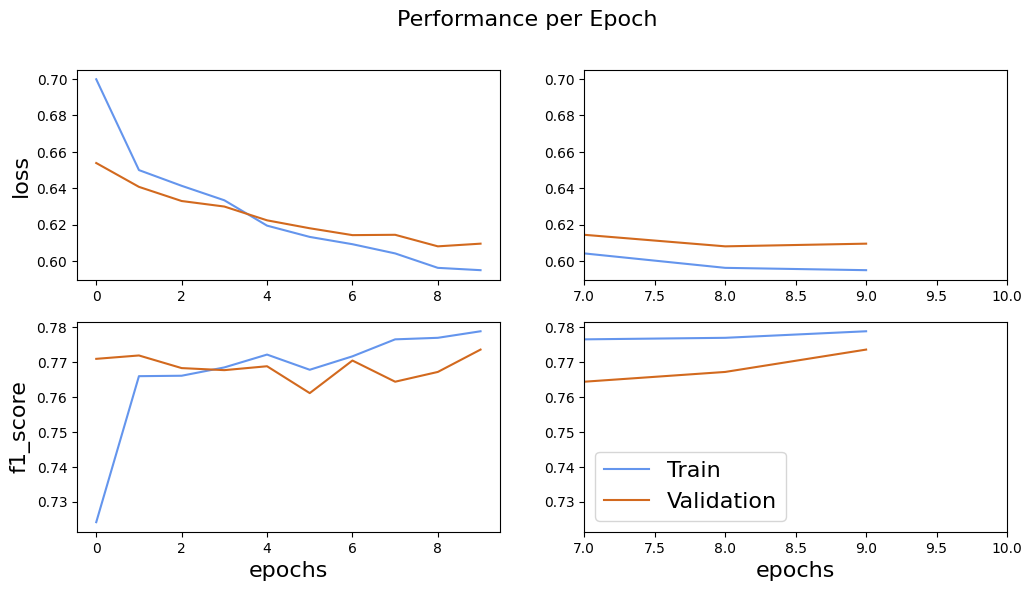

In [76]:
plot_history(history, 'f1_score', name='model_history')

Evaluating the model on training and validation data (Avaliando o modelo nos dados de treino e de validação).

In [78]:
print(f'Train set evaluate: {model.evaluate(train_set, verbose=0)[1]:.4f}')
print(f'Validation set evaluate: {model.evaluate(val_set, verbose=0)[1]:.4f}')

Train set evaluate: 0.8146
Validation set evaluate: 0.7672


Evaluating the final model on the test set (Avaliando o modelo final no test set).

In [80]:
print(f'Test set evaluate: {model.evaluate(test_set, verbose=0)[1]:.4f}')

Test set evaluate: 0.7641
